In [1]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm 
from zipfile import ZipFile

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
with ZipFile("../input/data-science-bowl-2018/stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("../input/data-science-bowl-2018/stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test")    

In [3]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 3

TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

train_ids[:5]

['1d5f4717e179a03675a5aac3fc1c862fb442ddc3e373923016fd6b1430da889b',
 '220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d96ed98015ab5ba538a',
 'ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8',
 '91cc2e0d4d6e2c1ad59a8d63bcbe3e2ea8bc7f8e642e942a0113450181e73379',
 '4948e3dfe0483c2198b9616612071ead5474dffd223071cf0a567aea9aca0b9e']

In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, file_name in tqdm(enumerate(train_ids)):   
    path = TRAIN_PATH + file_name
    img = imread(path + '/images/' + file_name + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Resizing training images and masks


0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
670it [05:11,  2.15it/s]


In [6]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 46.66it/s]

Done!


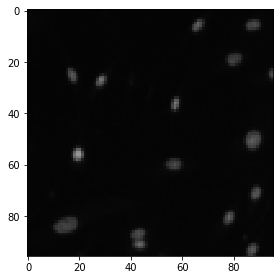

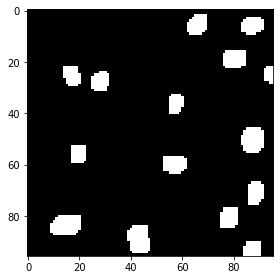

In [7]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [8]:
!pip install segmentation-models
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
smooth = 1.
dropout_rate = 0.5


# Custom loss function
# def dice_coef(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(K.dot(y_true_f , y_pred_f))
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1 - dice_coef(y_true, y_pred)

# def bce_dice_loss(y_true, y_pred):
#     return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

import keras
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
# from metrics import dice_loss, dice_coef, iou
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
physical_devices = tf.config.experimental.list_physical_devices('GPU')

class UNetPlusPlus():
    
    
    
    def __init__(self, input_shape = (96, 96, 3), filters = [32, 64, 128, 256, 512], nb_classes = 1, deep_supervision = False):
        
       
        self.input__shape = input_shape
        self.filters = filters
        self.num_classes = nb_classes
        self.deep_supervision = deep_supervision
        self.__smooth = 1. 
    
    def BuildNetwork(self):


        input_img = Input(shape = (96, 96, 3), name = 'InputLayer')
        
        conv00 = self.AadyasConvolutionBlock(input_img, block_level = '00', filters = self.filters[0])
        pool0 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool0')(conv00)

        conv10 = self.AadyasConvolutionBlock(pool0, block_level = '10', filters = self.filters[1])
        pool1 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool1')(conv10)

        up01 = Conv2DTranspose(filters = self.filters[0], kernel_size = 2, strides = 2, padding='same', name='upsample01')(conv10)
        conv01 = concatenate([up01, conv00], name='concat01')
        conv01 = self.AadyasConvolutionBlock(conv01, block_level = '01', filters = self.filters[0])

        conv20 = self.AadyasConvolutionBlock(pool1, block_level = '20', filters = self.filters[2])
        pool2 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool2')(conv20)

        up11 = Conv2DTranspose(filters = self.filters[1], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample11')(conv20)
        conv11 = concatenate([up11, conv10], name = 'concat11')
        conv11 = self.skip_path(conv11, block_level = '11', filters = self.filters[1])

        up02 = Conv2DTranspose(filters = self.filters[0], kernel_size = 2, strides = 2, padding='same', name='upsample02')(conv11)
        conv02 = concatenate([up02, conv00, conv01], name = 'concat02')
        conv02 = self.AadyasConvolutionBlock(conv02, block_level = '02', filters = self.filters[0])

        conv30 = self.AadyasConvolutionBlock(pool2, block_level = '30', filters = self.filters[3])
        pool3 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool3')(conv30)

        up21 = Conv2DTranspose(filters = self.filters[2], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample21')(conv30)
        conv21 = concatenate([up21, conv20], name='concat21')

        conv21 = self.AadyasConvolutionBlock(conv21, block_level='21', filters = self.filters[2])

        up12 = Conv2DTranspose(filters = self.filters[1], kernel_size = 2, strides = 2, padding='same', name = 'upsample12')(conv21)
        conv12 = concatenate([up12, conv10, conv11], name = 'concat12')
        conv12 = self.skip_path(conv12, block_level = '12', filters = self.filters[1])

        up03 = Conv2DTranspose(filters = self.filters[0], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample03')(conv12)
        conv03 = concatenate([up03, conv00, conv01, conv02], name = 'concat03')
        conv03 = self.AadyasConvolutionBlock(conv03, block_level = '03', filters = self.filters[0])

        conv40 = self.AadyasConvolutionBlock(pool3, block_level = '40', filters = self.filters[4])

        up31 = Conv2DTranspose(filters = self.filters[3], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample31')(conv40)
        conv31 = concatenate([up31, conv30], name = 'concat31')
        conv31 = self.skip_path(conv31, block_level = '31', filters=self.filters[3])

        up22 = Conv2DTranspose(filters = self.filters[2], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample22')(conv31)
        conv22 = concatenate([up22, conv20, conv21], name = 'concat22')
        conv22 = self.skip_path(conv22, block_level = '22', filters = self.filters[2])

        up13 = Conv2DTranspose(filters = self.filters[1], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample13')(conv22)
        conv13 = concatenate([up13, conv10, conv11, conv12], name='concat13')
        conv13 = self.skip_path(conv13, block_level = '13', filters = self.filters[1])

        up04 = Conv2DTranspose(filters = self.filters[0], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample04')(conv13)
        conv04 = concatenate([up04, conv00, conv01, conv02, conv03], name = 'concat04')
        conv04 = self.AadyasConvolutionBlock(conv04, block_level = '04', filters = self.filters[0])

        nested_op_1 = Conv2D(filters = self.num_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op1')(conv01)

        nested_op_2 = Conv2D(filters = self.num_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op2')(conv02)

        nested_op_3 = Conv2D(filters = self.num_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding= 'same', name = 'op3')(conv03)

        nested_op_4 = Conv2D(filters = self.num_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op4')(conv04)

        if self.deep_supervision:
            output = [nested_op_1, nested_op_2, nested_op_3, nested_op_4]
        else:
            output = [nested_op_4]

        model = Model(inputs = input_img, outputs = output, name = "UNetPP")

        return model

    
    def skip_path(self, input_tensor, block_level, filters, kernel_size = 3):

        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_1')(input_tensor)

        x = Dropout(rate = 0.5, name = 'X' + block_level + '_')(x)

        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_2')(x)

        x = Dropout(rate = 0.5, name = 'X' + block_level)(x)

        return x

    def AadyasConvolutionBlock(self, input_tensor, block_level, filters, kernel_size = 3):


        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_1')(input_tensor)

        x = Dropout(rate = 0.5, name = 'X' + block_level + '_')(x)

        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_2')(x)

        x = Dropout(rate = 0.5, name = 'X' + block_level)(x)

        return x

    
    def CompileAndSummarizeModel(self, model, optimizer=Adam(learning_rate = 0.0001)):

        
        model.compile(optimizer = optimizer, 
                      loss = 'binary_crossentropy',
                       metrics = iou
                     )
        
        model.summary()


In [10]:
#Modelcheckpoint
UNetPlusPlus_ = UNetPlusPlus()
model = UNetPlusPlus_.BuildNetwork()
UNetPlusPlus_.CompileAndSummarizeModel(model = model)


results = model.fit(x = X_train, y = Y_train,batch_size=16, epochs=1200)

Model: "UNetPP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv00_1 (Conv2D)               (None, 96, 96, 32)   896         InputLayer[0][0]                 
__________________________________________________________________________________________________
X00_ (Dropout)                  (None, 96, 96, 32)   0           conv00_1[0][0]                   
__________________________________________________________________________________________________
conv00_2 (Conv2D)               (None, 96, 96, 32)   9248        X00_[0][0]                       
_____________________________________________________________________________________________

In [11]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 124ms/step


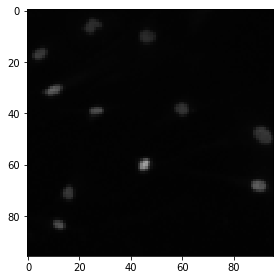

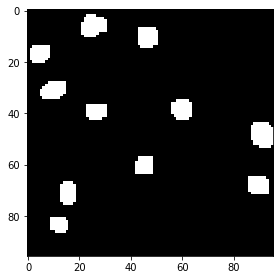

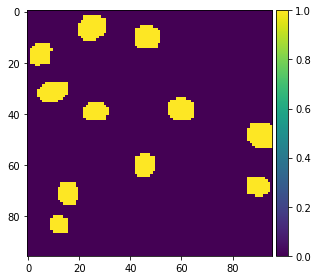

In [14]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

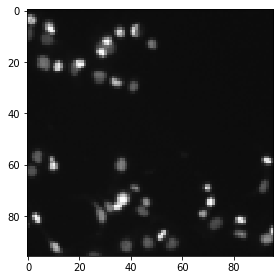

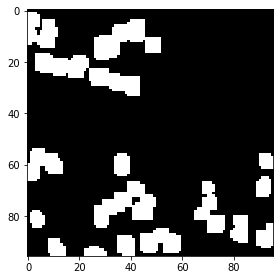

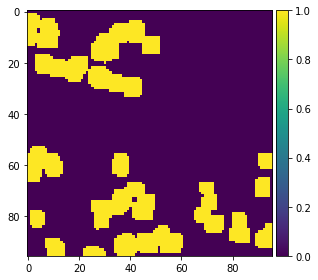

In [13]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()